
<img src="img/viu_logo.png" width="200">

## 01MIAR - Generadores de Datos

![logo](img/python_logo.png)

*Ivan Fuertes*

# Sumario
- Generadores en Python
- Expresiones Generadoras
  - Pipelines de datos
- Generadores para entrenar modelos
- Generadores de imágenes
  - Flow
  - Augmentations
- Generadores de datos custom

## Generadores en Python
- Yield
- Iterador Lazy

In [ ]:
# Devuelve lista
def squares(n):
    result = []
    for i in range(n):
        result.append(i ** 2)
    return result

In [ ]:
for i in squares(5):
    print(f"{i}")

In [ ]:
# Usar generador
def squares(n):
    for i in range(n):
        yield i ** 2

In [ ]:
for i in squares(5):
    print(f"{i}")

- Next (envia None al generador)

In [ ]:
x = squares(5)
print(type(x))

In [ ]:
next(x)

- Send (se pueden enviar valores en cada iteración)

In [ ]:
# Generator recibe datos
def gen():
    for i in range(10):
        x = yield i
        print(f"{x} inside function")

In [ ]:
g = gen()

In [ ]:
next(g)

In [ ]:
g.send(5)

## Expresiones Generadoras
- Comprehension List

In [ ]:
# Comprehension List
squares_cl = [num ** 2 for num in range(5)]
print(squares_cl)
print(type(squares_cl))

- Generator Expressions

In [ ]:
# Cambia [] por ()
squares_ge = (num ** 2 for num in range(5))
print(squares_ge)

In [ ]:
next(squares_ge)

## Pipelines de Datos con Generadores

- Pipeline -> Generadores encadenados

- A partir de un fichero csv
  - Leer una línea
  - Dividir cada línea en una lista de valores
  - Extraer nombres de las columnas
  - Usar nombres de las columnas para crear un diccionario con los datos de cada línea
  - Filtrar los datos en base a algún criterio
  - Calcular algún valor para dichos criterios

In [ ]:
from os import path
file_name = path.join("res", "titanic.csv")

In [ ]:
# GenExpr 01 -> Leer linea del fichero
lines = (line for line in open(file_name))
print(lines)

In [ ]:
# GenExpr 02 -> Dividir cada linea
list_line = (s.rstrip().split(",") for s in lines)
print(lines)

In [ ]:
cols = next(list_line)

In [ ]:
print(cols)

In [ ]:
# GenExpr 03 -> Diccionario, keys=nombre columna
passengers = (dict(zip(cols, data)) for data in list_line)
print(passengers)

In [ ]:
# GenExpr 04 -> Filtrado de datos
passenger_in_class3_survived = (
    int(passenger["Survived"])
    for passenger in passengers
    if int(passenger["Pclass"]) == 3
)

In [ ]:
# Usa el Pipeline
passengers_in_class3_survived = sum(passenger_in_class3_survived)

In [ ]:
print(passengers_in_class3_survived)

## Generadores para entrenar modelos

- Fichero de millones de líneas
- Mapeado lineal - y:f(x) = x

| x | y |
|---|---|
| 1 | 1 |
| 2 | 2 |
| 3 | 3 |
....

In [ ]:
from os import path
lineal_map = path.join("res", "huge_lineal_map.csv")

# Numero de filas
num_rows = 5000000

In [ ]:
# Crea fichero de prueba
with open(lineal_map, "w") as f:
    for i in range(num_rows):
        f.write(f"{i},{i}\n")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

- Función para leer el fichero en batches

In [ ]:
batch_size = 250

In [ ]:
# Carga Datos
def generate_arrays_from_file(path, batchsize):
    inputs = []
    targets = []
    batchcount = 0
    while True:
        with open(path) as f:
            for line in f:
                x,y = line.split(',')
                inputs.append(x)
                targets.append(y)
                batchcount += 1
                if batchcount > batchsize:
                    X = np.array(inputs, dtype='float32')
                    y = np.array(targets, dtype='float32')
                    yield (X, y)
                    inputs = []
                    targets = []
                    batchcount = 0

In [ ]:
# Crea el modelo
model = Sequential()
model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
# Compila el modelo
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mean_squared_error'])

In [ ]:
# Entrena el modelo
model.fit(generate_arrays_from_file(lineal_map, batch_size), 
            steps_per_epoch=num_rows / batch_size, epochs=2)

In [ ]:
model.predict([13504, 22330, 98771])

## Generadores de datos de imágenes con Keras

- ImageDataGenerator

### flow_from_directory
- Alimentar el generador desde un directorio de imágenes
- Fotos de una misma categoría deben ubicarse en una carpeta con el nombre de la clase
- Tamaño de lotes
- Redimensión de imágenes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from os import path
images_folder = path.join("res", "images")
n_images = 22

In [ ]:
# Apuntar al generador al directorio de imagenes
data_generator = ImageDataGenerator()
generator = data_generator.flow_from_directory(images_folder, batch_size=1, target_size=(300, 300))

In [ ]:
print(f"{generator.class_indices}")
indices_classes = {v: k for k, v in generator.class_indices.items()}

In [ ]:
for _ in range(n_images):
    images, labels = next(generator)
    plt.imshow((images[0].astype(int)))
    plt.show()

    print(f"Label = {indices_classes[np.argmax(labels[0])]} {labels[0]}")

- Usar generador como conjunto de datos para entrenamiento o para validación

In [ ]:
# model.fit(generator, epochs = epochs, validation_data = generator_val)

### flow

- Alimentar el generador desde arrays NumPy
- MNIST https://en.wikipedia.org/wiki/MNIST_database

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Carga dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
x_train = np.expand_dims(x_train, axis=-1)  #to fit flow rank 4 demands (nimages, width, height, depth)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape)  

print(type(x_train))

In [ ]:
# Crear y compilar modelo
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))
 
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

In [ ]:
# Generadores para entrenamiento y validacion
training_generator = datagen.flow(x_train, y_train, batch_size=64,subset='training',seed=7)
validation_generator = datagen.flow(x_train, y_train, batch_size=64,subset='validation',seed=7)

In [ ]:
# Visualiza imagenes del generador
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_generator:
        plt.imshow((x[0]/255).reshape(28,28),cmap='gray')
        plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [ ]:
# Entrena el modelo
model.fit(training_generator, steps_per_epoch=(len(x_train)*0.8)//64, epochs=4, 
          validation_data=validation_generator, validation_steps=(len(x_train)*0.2)//64)

In [ ]:
# Verificar precision del entrenamiento
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy={score[1]}")

### Augmentations
- Transformaciones, variaciones de imágenes
- Data Augmentation
- https://www.pexels.com/photo/brown-animal-1454786/

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import tensorflow.keras

In [103]:
from os import path
meerkat_path = path.join("res", "meerkat.jpg")

In [104]:
# Carga la imagen, convierte a ndarray y expande las dimensiones
img = load_img(meerkat_path)
img = img_to_array(img)

print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)

(750, 500, 3)
(1, 750, 500, 3)


In [105]:
# Visualizar muestras de augmentations
def show_augmentations(generator):
    plt.figure(figsize=(5,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        for x in generator:
            plt.imshow(x[0]/255.)
            plt.xticks([])
            plt.yticks([])
            break
    plt.tight_layout()
    plt.show()

| Método | Descripción | Valor Muestra |
|--------|-------------|---------------|
| rotation_range | Rotación | 45 |
| width_shift_range | Desplazamiento horizontal | 0.3 |
| height_shift_range | Desplazamiento vertical | 0.3 |
| brightness_range | Rango de brillo | [0.1, 0.9] |
| rescale | Normaliza valores de pixels a un rango | 1/255. |
| shear_range | Shear | 45 |
| zoom_range | Zoom | 0.5 |
| channel_shift_range | Canales | 100 |
| horizontal_flip | Espejo en horizontal | True |
| vertical_flip | Espejo en vertical | True |
| preprocessing_function | Aplica función | f() |

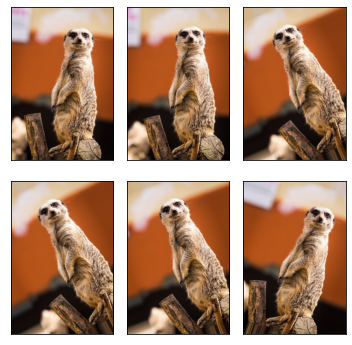

In [106]:
# Crear un generador con el metodo de augmentation
image_gen = ImageDataGenerator(rotation_range = 45)                   # rotation
# image_gen = ImageDataGenerator(width_shift_range = 0.2)               # desplazamiento horizontal
# image_gen = ImageDataGenerator(brightness_range = [0.1, 0.9])         # brillo
# image_gen = ImageDataGenerator(rescale = 1/255.)                      # normaliza valores de pixel (0,255) a (0,1)
# image_gen = ImageDataGenerator(shear_range = 40)                      # shear
# image_gen = ImageDataGenerator(zoom_range = 0.5)                      # zoom
# image_gen = ImageDataGenerator(channel_shift_range = 255)             # canales de color
# image_gen = ImageDataGenerator(vertical_flip = True)                  # flip
# image_gen = ImageDataGenerator(preprocessing_function = blur)         # custom function

generator = image_gen.flow(img, batch_size=1)

show_augmentations(generator)

In [ ]:
import cv2

def blur(img):
    return (cv2.blur(img,(8,8)))

## Generadores de datos custom con Keras

- A medida
- Sequence, clase base
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

In [107]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [ ]:
# Clase debe sobreescribir algunos metodos 
class CustomDataGenerator(tf.keras.utils.Sequence):
    
    # Inicializacion
    def __init__(self, data, batch_size, *args, **kwargs):
        self.data = data
        self.batch_size = batch_size
        pass

    # Devuelve el numero de batches
    def __len__(self):    
        return total_data / self.batch_size

    # Devuelve un batch de datos
    def __getitem__(self, index):   
        return X, y

    # Metodo opcional para ejecutar algo al final de cada epoch, (mezclar datos)
    def on_epoch_end(self):
        pass

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    
    # Inicializacion
    def __init__(self, data, x_col, y_col=None, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.data = data
        self.indices = self.data.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.on_epoch_end()

    # Devuelve el numero de batches
    def __len__(self):
        return len(self.indices) // self.batch_size

    # Devuelve un batch de datos
    def __getitem__(self, index):
        # Genera indices del batch
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # Encuentra la lista de ID's
        batch = [self.indices[k] for k in index]
        
        # Genera los datos
        X, y = self.__get_data(batch)
        return X, y

    # Metodo opcional para ejecutar algo al final de cada epoch, (mezclar datos)
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    # Metodo privado para la generacion de datos
    def __get_data(self, batch):
        X = []  # logica para cargar los datos de ficheros
        y = []  # logica para las variables target
        
        # Generar los datos
        for i, id in enumerate(batch):
            # Guardar un sample
            X[i,] = # logica para generar un sample (preprocesar/aumentar)
            y[i] = # etiquetas

        return X, y      

In [ ]:
# Usar un custom data set generator
train_generator = CustomDataGenerator(dataframe, batch_size = 32, num_classes = 2, shuffle = True)
validation_generator = CustomDataGenerator(dataframe, batch_size = 32, num_classes = 2, shuffle = True)

model.fit(train_generator, epochs, validation_data=validation_generator)